BloomTech Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting
You will use your portfolio project dataset for all assignments this sprint.



## Assignment
Complete these tasks for your project, and document your work.

- Try xgboost.
- Get your model's permutation importances.


## Business Scenario

Lending Club is an American lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientists, we will be building a model that can help in predicting whether a loan will not be paid back.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data).

### Original Data Dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

In [2]:
# Import Libraries

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE # to fix imbalance data
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [3]:
# Path to dataset
DATA_PATH = '/content/loan_data.csv'

## I. Wrangle Data

In [4]:
def wrangle(filepath):
  """
  This function performs data wrangling on the given dataset. It reads the dataset from the provided file path,
  replaces periods in column names with underscores, sets the data type of the 'purpose' column as category,
  handles outliers in the 'log_annual_inc' feature, performs feature engineering to create new columns,
  and drops the columns used for feature engineering to prevent data leakage.

  Parameters:
  - filepath (str): The file path of the dataset to be read.

  Returns:
  - loans (DataFrame): The cleaned and feature-engineered dataset.
  """
  loans = pd.read_csv(filepath)

  # Replacing period in column names with underscore
  loans.columns = loans.columns.str.replace(".", "_", regex=True)

  # Set data type of 'purpose' column as category
  loans['purpose'] = loans['purpose'].astype('category')

  # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
  def find_outlier_limits(col_name):
      Q1,Q3=loans[col_name].quantile([.25,.75])
      IQR=Q3-Q1
      low=Q1-(1.5* IQR)
      high=Q3+(1.5* IQR)
      return (high,low)

  high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

  # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits
  loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
  loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc

  # Feature engineering
  loans['credit_score_cat'] = np.where(loans['fico'] >= 670, 'Good/Excellent', 'Fair/Poor')
  loans['multiple_hard_inq'] = np.where(loans['inq_last_6mths'] > 2, 1, 0)
  loans['cr_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x > 30 or x == 0) else 0)

  # To avoid data leakage let's drop the columns used to do feature engineering
  loans.drop(columns=['fico', 'inq_last_6mths', 'revol_util'], inplace=True)

  return loans

In [5]:
# Read data
loans = wrangle(DATA_PATH)

# Print a sample of the data
display(loans.sample(10))

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,delinq_2yrs,pub_rec,not_fully_paid,credit_score_cat,multiple_hard_inq,cr_util_rate
3782,1,debt_consolidation,0.1253,167.34,10.545341,19.14,2220.000000,19876,0,0,0,Good/Excellent,0,1
4525,1,all_other,0.1322,67.61,10.915088,9.77,5250.000000,1083,0,0,0,Good/Excellent,1,1
5352,1,debt_consolidation,0.0859,347.72,9.952278,16.46,3629.958333,4372,0,0,1,Good/Excellent,0,0
1441,1,educational,0.1241,260.61,11.141862,11.50,1920.000000,36081,0,1,0,Good/Excellent,0,1
2437,1,debt_consolidation,0.1347,227.29,11.187251,14.21,5760.041667,53683,0,0,0,Good/Excellent,0,1
2725,1,all_other,0.1537,104.54,11.002100,1.00,1800.000000,1048,0,0,1,Good/Excellent,0,1
7417,1,all_other,0.1273,201.40,10.950807,7.73,4680.041667,0,1,2,0,Good/Excellent,0,1
7392,1,debt_consolidation,0.1136,164.56,10.714418,6.51,4620.041667,5971,0,1,0,Good/Excellent,0,1
964,1,all_other,0.1134,131.60,11.561716,11.04,1650.000000,1527,0,1,0,Good/Excellent,0,1
3193,1,major_purchase,0.1158,118.85,10.404263,23.60,1651.958333,10018,0,0,0,Good/Excellent,0,1


## II. Split Data

Perform a random split with cross-validation on the training set for model evaluation. This provides a more robust evaluation by reducing the impact of any particular data split and gives a better estimate of the model's performance on unseen data.

In [6]:
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [7]:
# Randomly split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

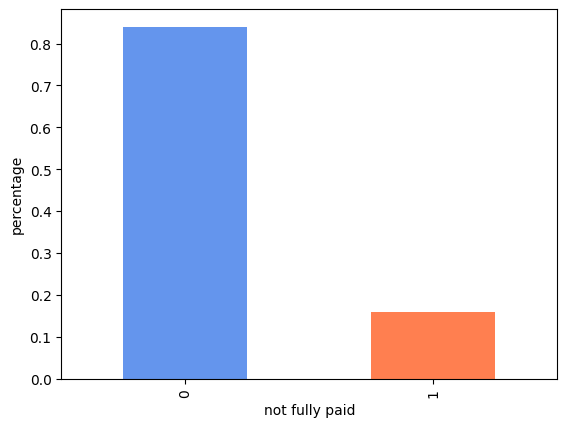

In [8]:
# Let's take a look at the distribution of the target
y_train.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral'])
plt.xlabel('not fully paid')
plt.ylabel('percentage');

Close to 84% of the instances are labeled as fully paid (class 0) and about 16% are labeled as not fully paid (class 1). This indicates an imbalanced class distribution.

## III. Establish Baseline

The baseline refers to the score or performance that we would achieve by simply guessing or using a basic rule without any predictive modeling. It serves as a reference point to evaluate the effectiveness of our predictive models.

In [9]:
# Majority Class
print('Majority Class:', y_train.value_counts(normalize=True).idxmax())

Majority Class: 0


In [10]:
# Assuming y_train contains the true labels for the training set
baseline_guess = [0] * len(y_train)  # Assigning 0 (majority class) to all instances
baseline_f1_score = f1_score(y_train, baseline_guess)

print("Baseline F1-score:", baseline_f1_score)

Baseline F1-score: 0.0


In [11]:
print('Baseline accuracy', y_train.value_counts(normalize=True).max())

Baseline accuracy 0.8397285304098147


## IV. Build XGBoost Model and Evaluate Metrics

We will develop an XGBoost model for training and tuning, using the F1-score as the evaluation metric. The F1-score considers both false positives (approving loans to potential defaulters) and false negatives (missing out on potential good borrowers).

We will apply the SMOTE (Synthetic Minority Over-sampling Technique) technique to balance the classes in our dataset before training and tuning the XGBoost model. SMOTE generates synthetic samples of the minority class to increase its representation and create a balanced training set. This will help us address the class imbalance issue in the data and improve the model's performance.

Additionally, we will compare the results of the XGBoost model with the tuned versions of logistic regression and random forest models obtained in the previous notebook.


In [12]:
%%time
# Model 3 - Balanced XGBoost

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti','days_with_cr_line',
                                   'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline with preprocessing, oversampling, undersampling, and model
bal_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=42))
])

# Fit the model
bal_xgb_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_xgb_scores = cross_val_score(bal_xgb_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', bal_xgb_scores)
print('F1 score Balanced XGB:', bal_xgb_scores.mean())

Cross-Validation Scores: [0.21004566 0.25396825 0.23129252 0.29875519 0.25165563]
F1 score Balanced XGB: 0.24914344978731556
CPU times: user 51.7 s, sys: 196 ms, total: 51.9 s
Wall time: 30.5 s


In [13]:
%%time
# Perform cross-validation and obtain predicted labels
bal_xgb_y_pred = cross_val_predict(bal_xgb_model, X_train, y_train, cv=cv)

# Balanced XGBoost Classification Report
print('Balanced XGBoost Classification Report: ')
print(classification_report(y_train, bal_xgb_y_pred))


Balanced XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6434
           1       0.27      0.23      0.25      1228

    accuracy                           0.78      7662
   macro avg       0.57      0.56      0.56      7662
weighted avg       0.76      0.78      0.77      7662

CPU times: user 40.1 s, sys: 129 ms, total: 40.2 s
Wall time: 22.7 s


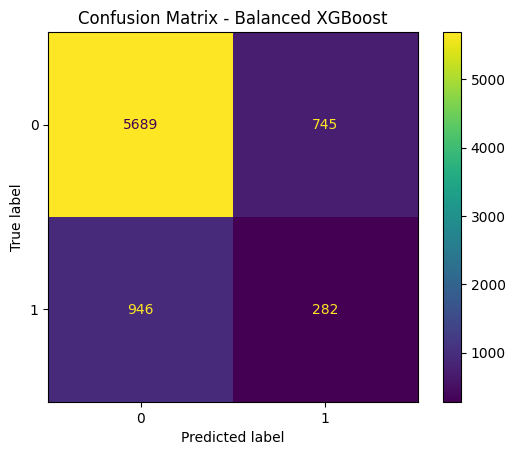

In [14]:
# Plot Confusion Matrix

cm = confusion_matrix(y_train, bal_xgb_y_pred, labels=bal_xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bal_xgb_model.classes_)
disp.plot()
plt.title('Confusion Matrix - Balanced XGBoost')
plt.show()

In the context of fully paid loans and not fully paid loans (loan defaulters), we can interpret the confusion matrix as follows:

- True Label 0 (Fully Paid Loans) and Predicted Label 0 (Predicted Fully Paid Loans) have a count of 5689. These are the instances where the model correctly predicted the fully paid loans. These are the true negatives, indicating instances that were actually fully paid and were correctly classified as fully paid by the model.

- True Label 1 (Not Fully Paid Loans) and Predicted Label 0 (Predicted Fully Paid Loans) have a count of 946. These are the instances where the model incorrectly predicted the fully paid loans instead of the not fully paid loans. These are the false negatives, indicating instances that were actually not fully paid or loan defaulters but were mistakenly classified as fully paid by the model. This suggests that the model missed identifying 946 instances of loan defaulters.

- True Label 0 (Fully Paid Loans) and Predicted Label 1 (Predicted Loan Defaulters) have a count of 745. These are the instances where the model incorrectly predicted the loan defaulters instead of fully paid loans. These are the false positives, indicating instances that were actually fully paid but were mistakenly classified as loan defaulters by the model.

- True Label 1 (Not Fully Paid Loans) and Predicted Label 1 (Predicted Not Fully Paid Loans) have a count of 282. These are the instances where the model correctly predicted the loan defaulters. These are the true positives, indicating instances that were actually not fully paid or loan defaulters and were correctly classified as loan defaulters by the model.

## V. Hyperparameter Tuning

Perform hyperparameter tuning using randomized search technique. Explore various hyperparameter combinations and select the set of hyperparameters that maximizes the F1-score.

In [15]:
%%time
# Balanced XGBoost Tuning

# Define the parameter distribution
param_grid_xgb = {
    # Control how much the model learns from each mistake it makes
    'classifier__learning_rate': [0.01, 0.5, 1],
    # Number of decision trees to be built
    'classifier__n_estimators': range(100, 500, 100),
    # Maximum depth of each decision tree
    'classifier__max_depth': [3, 5, 10, 15],
}

# Create the randomized search object
rsearch_xgb = RandomizedSearchCV(estimator=bal_xgb_model, scoring='f1', param_distributions=param_grid_xgb, n_iter=10, cv=15, random_state=42, n_jobs=-1)

# Fit the randomized search to the training data
rsearch_xgb.fit(X_train, y_train)

# Print the best parameters and best score
print('Best Hyperparameters:', rsearch_xgb.best_params_)
print('Best Score:', rsearch_xgb.best_score_)


Best Hyperparameters: {'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.01}
Best Score: 0.31384421247587435
CPU times: user 29.8 s, sys: 3.7 s, total: 33.5 s
Wall time: 35min 55s


In [27]:
%%time
# Fitting the model with the tuned hyperparameters

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti','days_with_cr_line',
                                   'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline with preprocessing, oversampling, undersampling, and model
tuned_xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('classifier', XGBClassifier(objective='multi:softmax',
                                 num_class=len(np.unique(y_train)),
                                 random_state=42,
                                 n_estimators=100,
                                 max_depth=5,
                                 learning_rate=0.01))
])

# Fit the model
tuned_xgb_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
tuned_xgb_scores = cross_val_score(tuned_xgb_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', tuned_xgb_scores)
print('F1 score Balanced XGB:', tuned_xgb_scores.mean())

Cross-Validation Scores: [0.306914   0.31672598 0.34295416 0.32404181 0.28472222]
F1 score Balanced XGB: 0.31507163378728953
CPU times: user 45.6 s, sys: 0 ns, total: 45.6 s
Wall time: 26.4 s


In [30]:
%%time
# Perform cross-validation and obtain predicted labels
tuned_xgb_y_pred = cross_val_predict(tuned_xgb_model, X_train, y_train, cv=cv, n_jobs=-1)

CPU times: user 277 ms, sys: 44.4 ms, total: 322 ms
Wall time: 22.5 s


In [40]:
# Tuned XGBoost Classification Report
print('Tuned XGBoost Classification Report: ')
print(classification_report(y_train, tuned_xgb_y_pred))

Tuned XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      6434
           1       0.27      0.37      0.32      1228

    accuracy                           0.74      7662
   macro avg       0.57      0.59      0.58      7662
weighted avg       0.78      0.74      0.76      7662



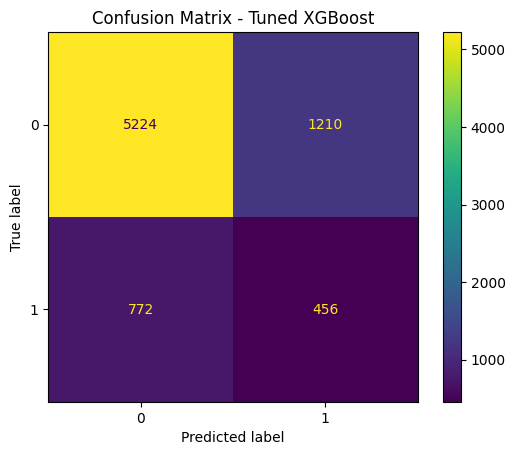

In [42]:
# Plot Confusion Matrix
cm = confusion_matrix(y_train, tuned_xgb_y_pred, labels=tuned_xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_xgb_model.classes_)
disp.plot()
plt.title('Confusion Matrix - Tuned XGBoost')
plt.show()

Based on the importance of the F1-score as the primary evaluation metric and the consideration for achieving good overall accuracy, the Tuned XGBoost model seems to be the better model choice.

Although the Balanced XGBoost model demonstrates higher precision, recall, and F1-score for both classes individually, the Tuned XGBoost model excels in terms of recall and F1-score specifically for class 1 (not fully paid loans) and achieves a higher macro average F1-score. This indicates that the Tuned XGBoost model is better at correctly identifying instances of loan default.

Additionally, it is important to note that the Tuned XGBoost model achieves a good overall accuracy, although slightly lower than the Balanced XGBoost model. However, considering the focus on the F1-score and the specific goal of predicting loan default risk, the Tuned XGBoost model provides a more balanced performance in terms of precision, recall, and F1-score for the critical class 1.

The process of tuning the XGBoost model involved exploring different hyperparameter search spaces. However, due to the computational expense and time required, it was not possible to exhaustively explore all possible combinations of hyperparameters. Not all search spaces resulted in satisfactory results, highlighting the challenges and trade-offs of hyperparameter tuning.

It is important to acknowledge the limitations of the search spaces used in this project and the need for careful consideration when designing them. Future experiments could explore more efficient hyperparameter optimization techniques, such as Bayesian optimization, to improve the tuning process.

The results indicate that the Tuned XGBoost model offers a more reliable and effective approach for predicting loan default risk compared to the Balanced XGBoost model, across all evaluated metrics.

## VI. Communicate Results

Which features are most important to our model when making predictions?

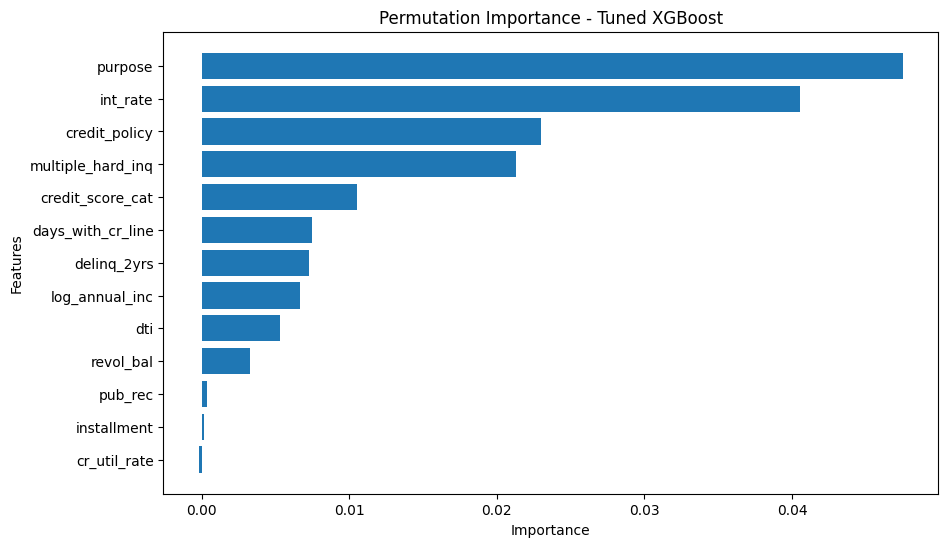

CPU times: user 10.6 s, sys: 124 ms, total: 10.7 s
Wall time: 8.27 s


In [33]:
%%time
# Perform permutation importance
result = permutation_importance(tuned_xgb_model, X_train, y_train, scoring='f1', n_repeats=10, random_state=42)

# Get feature importances and names
importances = result.importances_mean
feature_names = X_train.columns

# Sort feature importances in descending order
sorted_indices = importances.argsort()[::1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Permutation Importance - Tuned XGBoost')
plt.show()


In [37]:
%%time
data_perm = {'imp_mean':result['importances_mean'],
             'imp_std':result['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_train.columns).sort_values('imp_mean')
df_perm

CPU times: user 2.95 ms, sys: 0 ns, total: 2.95 ms
Wall time: 2.89 ms


,imp_mean,imp_std
cr_util_rate,-0.000215,0.000857
installment,0.000185,0.000722
pub_rec,0.000336,0.000651
revol_bal,0.003251,0.001242
dti,0.005286,0.001995
log_annual_inc,0.006637,0.002393
delinq_2yrs,0.007259,0.002141
days_with_cr_line,0.007496,0.001586
credit_score_cat,0.010517,0.003524
multiple_hard_inq,0.021288,0.004661


Based on the permutation importances, we can see that the most important features for predicting loan default risk are:

1. Purpose: This feature has the highest importance, indicating that the purpose of the loan plays a significant role in determining the likelihood of default.

2. Interest Rate: The interest rate is the second most important feature, suggesting that higher interest rates may be associated with a higher risk of default.

3. Credit Policy: The credit policy, which represents whether the customer meets the credit underwriting criteria of LendingClub, is also a significant predictor of loan default.

Other features such as credit score category, multiple hard inquiries, and days with a credit line also contribute to the model's performance but to a lesser extent. On the other hand, features like cr_util_rate, installment, pub_rec, and revol_bal have relatively lower importance or even negative values, indicating that they have less impact on predicting loan default risk.

These permutation importances provide valuable insights into the relative importance of different features and can be used to prioritize and focus on key factors when making decisions related to loan default risk assessment.

### Model Comparisons

| Metric              | Tuned LR | Tuned RF | Tuned XGBoost |
| ------------------- | -------- | -------- | ------------- |
| Accuracy            | 0.64     | 0.71     | 0.74          |
| Macro Avg F1        | 0.55     | 0.57     | 0.58          |
| Weighted Avg F1     | 0.69     | 0.74     | 0.76          |
| Precision (Class 0) | 0.89     | 0.88     | 0.87          |
| Precision (Class 1) | 0.24     | 0.26     | 0.27          |
| Recall (Class 0)    | 0.66     | 0.77     | 0.81          |
| Recall (Class 1)    | 0.58     | 0.44     | 0.37          |
| F1-Score (Class 0)  | 0.76     | 0.82     | 0.84          |
| F1-Score (Class 1)  | 0.34     | 0.33     | 0.32          |





The table above includes the metrics for the Tuned XGBoost model alongside the metrics for the Tuned Logistic Regression (LR) and Tuned Random Forest (RF) models. It provides a comparison of the performance of these three models in terms of accuracy, macro average F1-score, weighted average F1-score, precision, recall, and F1-score for each class.

For identifying borrowers more likely to default (class 1), the Tuned XGBoost model achieves a precision of 0.27, recall of 0.37, and F1-score of 0.32.
Considering these metrics, the Tuned XGBoost model is still the best model among the three options. It demonstrates higher recall, and F1-score for class 0 (fully paid loans) compared to the other models. While the precision, recall, and F1-score for class 1 (not fully paid loans) are relatively low.

It's important to note that predicting loan defaults is a challenging task and achieving high accuracy for both classes simultaneously can be difficult. Therefore, in this business scenario, the Tuned XGBoost model remains the recommended choice for predicting loan default risk.



